In [168]:
# NLP stuff
from textblob import classifiers
from newsapi import NewsApiClient

# fastai, a super useful open-source ML library
from fastai.fastai.imports import *
from fastai.old.fastai.structured import *
from datetime import datetime, timedelta
from nltk.classify.scikitlearn import SklearnClassifier
import nltk

# Random Forest stuff
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import pandas as pd
from sklearn import metrics

In [169]:
# finds RMSE between the prediction and the actuak
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

# function for print r2 and RMSE of training data and validation data
# also print oob_score (out of box score) if the model had that parameter
def print_score(rf):
    res = ["RMSE " + str(rmse(rf.predict(X_valid), y_valid)), "R^2 " + str(rf.score(X_valid, y_valid))]
    if hasattr(rf, 'oob_score_'): res.append(rf.oob_score_)
    print(res)
    
# splits dataset based on how many you want to train/validate
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [172]:
"""
Uses the data from 'From Group to Individual Labels using Deep Features', Kotzias et. al to train sentiment classifier
--------------------------------------------------------------------------------------------------------------------
THIS IS THE OLD CLASSIFIER. IT's INACCURACY WAS WHY WE MADE OUR OWN STOCK-FOCUSED NLP DATASET FOR SENTIMENT ANALYSIS
--------------------------------------------------------------------------------------------------------------------
For example, it would classify "stocks going down" as a neutral or maybe even positive thing, which it is not!
The number you see below is a bit deceptive in terms of accuracy, as it is less relevant to stock market discussions
"""

PATH1 = 'data/SentimentData/amazon_cells_labelled.txt'
PATH2 = 'data/SentimentData/imdb_labelled.txt'
PATH3 = 'data/SentimentData/yelp_labelled.txt'

amazon_data = pd.read_csv(PATH1, sep='\t', header=None, names=['sentence', 'sentiment'])
imdb_data = pd.read_csv(PATH2, sep='\t', header=None, names=['sentence', 'sentiment'])
yelp_data = pd.read_csv(PATH3, sep='\t', header=None, names=['sentence', 'sentiment'])

# makes the combined data
total_data = amazon_data
total_data = total_data.append(imdb_data, ignore_index=True)
total_data = total_data.append(yelp_data, ignore_index=True)

train_data_full = [tuple(x) for x in total_data.values]
train_data = train_data_full[:2000]
print(len(train_data))

print('training Old NLP classifier...')
print()
oldClassifier = classifiers.NaiveBayesClassifier(train_data)
oldClassifier.train()
print('done. Accuracy: ')
oldClassifier.accuracy(train_data_full[2000:])

2000
training Old NLP classifier...

done. Accuracy: 


0.7593582887700535

In [179]:
"""
This kernel contains all the code to parse sentiment for a given company on a given day
API: Google News API
-One function scans the top 5 articles from the given date to one week before, parses the title and summary for each, and
sends it in a list
-Another function uses a classifier (IMPLEMENTED BELOW) to evaluate the articles
-The wrapper combines both for easy access
"""

key = '25b7d80a029b490dbfc0b201a4f83e81'
news = NewsApiClient(api_key=key)

ARTICLE_COUNT = 5
# finds the relevant news articles for a company on a day
# current_date should be in form "YYYY-MM-DAY"
def parse_articles_on_date(company_name, current_date):
    # this calculates the day one week ago
    DAYS_BACK = 7
    year, month, day = tuple(current_date.split('-'))
    new_date = datetime(int(year), int(month), int(day)) - timedelta(DAYS_BACK)
    start_day = str(new_date)[:10]
    
    company_data = []
    query = company_name + " Stock News"
    all_articles = news.get_everything(q=query, from_param=start_day,to=current_date, language='en', sort_by='relevancy')
    article_data = all_articles['articles']
    for i in range(ARTICLE_COUNT):
        try:
            titlePlusSummary = article_data[i]['title'] + '. ' + article_data[i]['description']
            company_data.append(titlePlusSummary)
        except:
            break
    return company_data

# takes data found from parse_articles_on_date and determines the score using the classifier
def calculate_score(classifer, company_data):
    count = 0
    output = 0
    for summary in company_data:
        try:
            output += classifier.prob_classify(summary).prob(1)
            count += 1
        except:
            continue
    if count > 0:
        return output / count
    else:
        return 0

# a wrapper on the previous two functions
def article_scorer_wrapper(classifier, company_name, current_date):
    company_data = parse_articles_on_date(company_name, current_date)
    return calculate_score(classifier, company_data)

In [174]:
# this uses a dataframe and adds a column that has the value (close-open)/open per day to see the net change daily
def create_close_open_ratio(df):
    df["Close-Open Ratio"] = (df['close'].values-df['open'].values)/df['open'].values
    ratios = df["Close-Open Ratio"].values
    ratios += np.abs(np.min(ratios))
    ratios /= np.max(ratios, axis=0)
    df["Close-Open Ratio"] = ratios
    return df

In [180]:
"""
-----------------------------------------------------------------------------------------------
NOW STARTS THE NLP DATASET AND THEN MODEL CREATION
-----------------------------------------------------------------------------------------------
"""

'\n-----------------------------------------------------------------------------------------------\nNOW STARTS THE NLP DATASET AND THEN MODEL CREATION\n-----------------------------------------------------------------------------------------------\n'

In [181]:
# this creates the NLP dataframe, with sentence as one column, and the (c-o)/c ratio as the other
def create_sentiment_dataset(df, company_name):
    for i in range(len(df)):
        date = str(df['timestamp'][i])[:10]
        # the API won't let me pull more than a month back, so this is an ad-hoc fix
        if date == '2019-01-23':
            break
        articles = parse_articles_on_date(company_name=company_name, current_date=date)
        toAdd = pd.DataFrame({'statement': articles,
                              'close-open ratio': df['Close-Open Ratio'][i]})
        if (i == 0):
            df_NLP = toAdd
        else:
            df_NLP = df_NLP.append(toAdd, ignore_index=True)
            
    return df_NLP

In [178]:
# these companies were chosen because they are competitors for the 4 companies we are asked to predict
# so, they're news is more relevant in terms of training an NLP classifier
company_list = ['MMM', 'BAYZF', 'SYF', 'HON', 'BHC', 'WFC', 'JPM', 'ALV', 'PFE', 'JNJ']
dateColumn = "timestamp"
first = True
for company in company_list:
    PATH = 'data/{}-TIME_SERIES_DAILY.csv'.format(company)
    df_new = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
    # creates the dataset for each company and appends to the main
    df_new = create_close_open_ratio(df_new)
    df_new = create_sentiment_dataset(df_new, company)
    if first:
        first = False
        df_NLP = df_new
    else:
        df_NLP = df_NLP.append(df_new, ignore_index=True)
    print(company + ' done')

# the dataframe with all the NLP data in the form (sentences, change in price ratio) per row
# the goal here was to correlate a sentence with a change in stock price
# by making our own dataset with that correlation, we can train an NLP classifer on stock sentiment
# as the classifier is really correlating words it has seen with the corresponding changes in stock
df_NLP

MMM done
BAYZF done
SYF done
HON done
BHC done
WFC done
JPM done
ALV done
PFE done
JNJ done


,statement,close-open ratio
0,Parker-Hannifin: Long-Term Opportunity At The ...,0.515954
1,This Is What Hedge Funds Bought And Sold In Th...,0.515954
2,The Best Dividend Stocks You Can Buy Today. Af...,0.515954
3,Kentucky Retirement Systems Insurance Trust Fu...,0.515954
4,Parker-Hannifin: Long-Term Opportunity At The ...,0.391018
5,Atalanta Sosnoff Capital Maintains Position in...,0.391018
6,The Best Dividend Stocks You Can Buy Today. Af...,0.391018
7,Kentucky Retirement Systems Insurance Trust Fu...,0.391018
8,Parker-Hannifin: Long-Term Opportunity At The ...,0.522787
9,Atalanta Sosnoff Capital Maintains Position in...,0.522787


In [186]:
# randomly shuffles the data
df_NLP = df_NLP.sample(frac=1)
# gets the data in a manner that can be run by text classifier models
values = df_NLP['close-open ratio'].values
values = values.astype(np.float)
values = np.around(values)
statements = df_NLP['statement'].values
train_data = [({'words': statements[i]}, values[i]) for i in range(500)]
test_data = [({'words': statements[i]}, values[i]) for i in range(500, len(df_NLP))]

from sklearn.svm import LinearSVC
# the classifier model!
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(train_data)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, test_data))*100)

LinearSVC_classifier accuracy percent: 82.95454545454545


In [188]:
"""
Now that a classifier has been made from the NLP dataset, the rest can continue
"""

'\nNow that a classifier has been made from the NLP dataset, the rest can continue\n'

In [189]:
PATH = 'data/BAYZF-TIME_SERIES_INTRADAY.csv'
PATH_SUPPL = 'data/BAYZF-TIME_SERIES_DAILY.csv'
dateColumn = "timestamp"

df_BAYZF = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_BAYZF.rename(index=str, columns={"open": "sale_price"}, inplace=True)
df_SUPPL = pd.read_csv(PATH_SUPPL, low_memory=False, parse_dates=[dateColumn])
data_suppl = df_SUPPL["open"].values

# add_datepart turns a date into a bunch of useful columns
add_datepart(df_BAYZF, dateColumn, time=True)
add_datepart(df_SUPPL, dateColumn, time=True)

In [134]:
start_hour = 9
start_minute = 30
end_hour = 4
end_minute = 0

"""
This kernel contains some meaty functions that basically help make new columns / restructure data in the given data
For example, df_BAYZF only has daily data when a sale is made. So, this restructures it so that it is every 5 minutes
"""

def day_to_start_price_map(df, price_field, indices=True, toCount=False):
    # map of unique_days to their starting price
    unique_days = {}
    counts = {}
    for row in range(len(df[price_field])):
        year = df["timestampYear"][row]
        month = df["timestampMonth"][row]
        week = df["timestampWeek"][row]
        day = df["timestampDay"][row]
        data = (year, month, week, day)
        if indices:
            if data in unique_days:
                unique_days[data].append(row)
            else:
                unique_days[data] = [row]
        else:         
            if data not in unique_days:
                unique_days[data] = df[price_field][row]
            else:
                unique_days[data] = df[price_field][row]
        if toCount:
            if data in counts:
                counts[data] += 1
            else:
                counts[data] = 1
    if toCount:
        return unique_days, counts
    
    return unique_days

# 6 hours * 12 five min intervals per hour + 6 five min intervals from 9:30 to 10
total_intervals = 6*12 + 6

# very long function that was used specifically for df_BAYZF as its data was only recorded when a sale was made
# turns it into data that is recored every 5 minutes from 9:30 to 4pm
def create_new_df(df_main, df_suppl, company_name, classifier):
    def assign_interval(hour, minute):
            if hour == 9:
                intervalCheck = (minute - 30) / 5
            else:
                intervalCheck = minute / 5 + (hour - 10)*12 + 6
            return intervalCheck
    
    day_to_price = day_to_start_price_map(df_main, "sale_price", True)
    day_to_price_start = day_to_start_price_map(df_suppl, "open", False)
    day_to_price_close = day_to_start_price_map(df_suppl, "close", False)
    first=True    
    for day_info in day_to_price:
        dataOpen = np.array([day_to_price_start[day_info] for interval in range(total_intervals)])
        dataClose = np.array([day_to_price_close[day_info] for interval in range(total_intervals)])
        dataPrice = []
        list_counter = -1
        indexInDf = day_to_price[day_info][list_counter]
        price = day_to_price_start[day_info]
        hourChange = df_main["timestampHour"][indexInDf]
        minuteChange = df_main["timestampMinute"][indexInDf]
        intervalCheck = assign_interval(hourChange, minuteChange)
        for interval in range(total_intervals):
            if interval == intervalCheck:
                # updates price as a change has been detected
                price = df_main["sale_price"][indexInDf]
                try:
                    # updates the list counter and the other variables
                    list_counter -= 1
                    indexInDf = day_to_price[day_info][list_counter]
                    hourChange = df_main["timestampHour"][indexInDf]
                    minuteChange = df_main["timestampMinute"][indexInDf]
                    intervalCheck = assign_interval(hourChange, minuteChange)
                except:
                    pass
            dataPrice.append(price)
            
        dataPrice = np.array(dataPrice)
        hours = np.array([0 for interval in range(total_intervals)])
        minutes = np.array([0 for interval in range(total_intervals)])
        for i in range(total_intervals):
            if i < 6:
                hours[i] = 9
                minutes[i] = 30 + 5*i
            else:
                minutes[i] = (5*(i-6) % 60)
                if i < 18:
                    hours[i] = 10
                elif i < 30:
                    hours[i] = 11
                elif i < 42:
                    hours[i] = 12
                elif i < 54:
                    hours[i] = 1
                elif i < 66:
                    hours[i] = 2
                else:
                    hours[i] = 3
                    
        year, month, week, day = day_info
        year = str(year)
        month = str(month)
        day = str(day)
        if (len(month) == 1):
            month = '0' + month
        if (len(day) == 1):
            day = '0' + day
        current_date = year + "-" + month + "-" + day
        sentiment_score = article_scorer_wrapper(classifier=classifier, company_name=company_name, current_date=current_date)
        sentiment_score_as_list = [sentiment_score for x in range(total_intervals)]
        toAdd = {"sale_price": dataPrice,
                 "price_close": dataClose,
                 "open": dataOpen,
                 "sentiment": sentiment_score_as_list,
                 "timestamp": str(month) + "/" + str(day) + "/" + str(year),
                 "hour": hours,
                 "minute": minutes}
        dfAdd = pd.DataFrame.from_dict(toAdd)
        
        if first:
            df_toReturn = dfAdd
            first=False
        else:
            df_toReturn = df_toReturn.append(dfAdd, ignore_index=True)
            
    return df_toReturn

In [190]:
# in a sense remake df_BAYZF using the classifier and the restructured format
df_BAYZF = create_new_df(df_BAYZF, df_SUPPL, company_name='Bayer', classifier=LinearSVC_classifier)
add_datepart(df_BAYZF, "timestamp")

In [191]:
df_BAYZF.head()

,sale_price,price_close,open,sentiment,hour,minute,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampElapsed
0,74.43,73.838,74.43,0.358132,9,30,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
1,74.43,73.838,74.43,0.358132,9,35,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
2,74.43,73.838,74.43,0.358132,9,40,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
3,74.43,73.838,74.43,0.358132,9,45,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
4,74.43,73.838,74.43,0.358132,9,50,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400


In [264]:
"""
kernel for preparing df_BAYZF to be passed into Random Forest and then actually creating the model
will use OPEN and CLOSE on a given day to predict INTERDAY price changes

IN PRACTICE: "close" would come from our model that predicts closing prices, thus leading to the model integration

"""
to_predict = "sale_price"
# proc_df is a fastai function that turns a df into its paramater data and output
# proc_df can also drop additional columns that you specify, and it fills in any missing values with the median
# to allow for continuous data
result = proc_df(df_BAYZF, y_fld=to_predict)
# df is all the columns of df_BAYZF minus the one being predicted
df = result[0]
# y is the output being predicted (in this case instantaneous day price)
y = result[1]

# this removes any instances where y is not an actual value as well as removing that row from the corresponding df row
to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 300 # predicts last day
n_train = len(df) - n_valid
# splits the data, note the data is NOT shuffled as it's already in order, so using first 80 rows to predict last 20
# is equivalent to predicting 20 rows "in the future"
raw_train, raw_valid = split_vals(df_BAYZF, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

# at last, makes the Random Forest Model using tuned hyperparameters
rf_BAYZF = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_BAYZF.fit(X_train, y_train)
print_score(rf_BAYZF)

['RMSE 0.31700232732383554', 'R^2 0.5687949172222317']


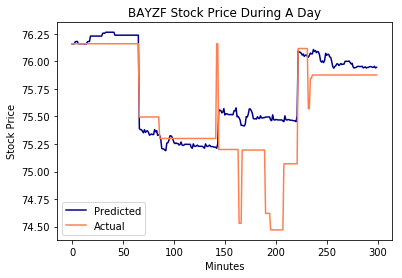

In [265]:
# code for plotting the predictions against the expected over "time"
preds = rf_BAYZF.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
plt.title("BAYZF Stock Price During A Day")
plt.xlabel('Minutes')
plt.ylabel('Stock Price')
plt.gca().legend(('Predicted','Actual'))
plt.show()

In [230]:
# to see how important various features were
rf_feat_importance(rf_BAYZF, df)

,cols,imp
1,open,0.352652
0,price_close,0.294549
17,timestampElapsed,0.132628
8,timestampDay,0.061733
9,timestampDayofweek,0.049899
10,timestampDayofyear,0.042169
3,hour,0.029570
2,sentiment,0.019775
7,timestampWeek,0.011796
4,minute,0.005228


In [231]:
# "open" in the dataset really meant the sale price, so this function creates a new open column and also a sentiment column
# this function is used by everyone but df_BAYZF
def create_open_and_sentiment_cols(df, company_name, classifier):
    res = day_to_start_price_map(df, "sale_price", False, True)
    day_to_price_start = res[0]
    counts = res[1]
    first = True
    for day_info in day_to_price_start:
        
        year, month, week, day = day_info
        year = str(year)
        month = str(month)
        day = str(day)
        if (len(month) == 1):
            month = '0' + month
        if (len(day) == 1):
            day = '0' + day
        current_date = year + "-" + month + "-" + day
        
        dataOpen = np.array([day_to_price_start[day_info] for interval in range(counts[day_info])])
        sentiment_score = article_scorer_wrapper(classifier=classifier, company_name=company_name, current_date=current_date)
        sentiment_score_as_list = np.array([sentiment_score for x in range(counts[day_info])])
        if first:
            first = False
            net_open_data = dataOpen
            net_sentiment_data = sentiment_score_as_list
        else:
            net_open_data = np.append(net_open_data, dataOpen)
            net_sentiment_data = np.append(net_sentiment_data, sentiment_score_as_list)
    df['open'] = net_open_data
    df['sentiment'] = net_sentiment_data
    return df

In [232]:
PATH = 'data/MMM-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_MMM = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_MMM.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_MMM, dateColumn, time=True)

df_MMM = create_open_and_sentiment_cols(df_MMM, company_name="3M", classifier=classifier)

In [267]:
to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_MMM, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 300 # predict last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_MMM, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_MMM = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_MMM.fit(X_train, y_train)
print_score(rf_MMM)

['RMSE 0.15260944471473487', 'R^2 0.5855648820862058']


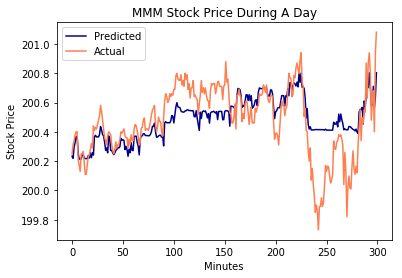

In [250]:
preds = rf_MMM.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
plt.title("MMM Stock Price During A Day")
plt.xlabel('Minutes')
plt.ylabel('Stock Price')
plt.gca().legend(('Predicted','Actual'))
plt.show()

In [283]:
PATH = 'data/HON-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_HON = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_HON.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_HON, dateColumn, time=True)

df_HON = create_open_and_sentiment_cols(df_HON, company_name="Honeywell", classifier=classifier)

to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_HON, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 300 # predict last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_HON, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_HON = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_HON.fit(X_train, y_train)
print_score(rf_HON) # this one didn't do as well

['RMSE 0.3344403267794573', 'R^2 -0.1467093322058357']


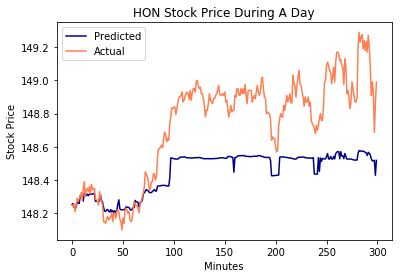

In [284]:
preds = rf_MMM.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
plt.title("HON Stock Price During A Day")
plt.xlabel('Minutes')
plt.ylabel('Stock Price')
plt.gca().legend(('Predicted','Actual'))
plt.show()

In [291]:
PATH = 'data/SYF-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_SYF = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_SYF.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_SYF, dateColumn, time=True)

df_SYF = create_open_and_sentiment_cols(df_SYF, company_name="Synchrony Financial", classifier=classifier)

to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_SYF, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 300 # predict last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_SYF, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_SYF = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_SYF.fit(X_train, y_train)
print_score(rf_SYF) # this one didn't do as well

['RMSE 0.060711324887890154', 'R^2 0.009252455150576266']


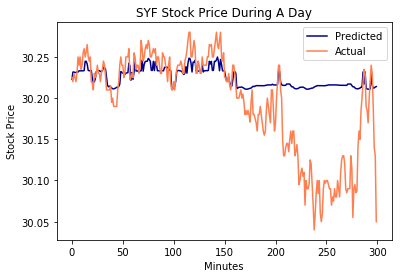

In [292]:
preds = rf_SYF.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
plt.title("SYF Stock Price During A Day")
plt.xlabel('Minutes')
plt.ylabel('Stock Price')
plt.gca().legend(('Predicted','Actual'))
plt.show()